In [1]:
# Required Libraries
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
from matplotlib import animation
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from sklearn.neighbors import NearestNeighbors
from IPython.display import HTML
plt.rcParams['text.usetex'] = False


# Tutorial: Visualizing Large-Scale Structure

This simple tutorial is designed to show how one could explore & visualize large-scale structure within the compilation. Several programs within the compilation were designed to specifically go after overdense regions to investigate the role of environment on galaxy evolution. The power of combining archival datasets is that we have the potential of better visualizing and tracing large-scale structure by including sources that were not part of the specific galaxy environment follow-up programs. In this tutorial, we will explore how we can create visualizations of the 3D space at specific redshift slices to explore the cosmic web using a simple nearest neighbor algorithm. This comes with several caveats with the major one being incompleteness. The selection function of the compilation is highly complex as we are combining datasets from various programs that had their own individual selection functions. This is not an issue in overdense regions where if we do see an overdensity within the compilation, then it does exist within that vicinity as sources were targeted and confirmed. However, an *isolated* galaxy can also be part of an overdensity with the problem that sources nearby were not spectroscopically followed up to confirm an overdensity.


## Visualizing Large-Scale Structure

First, we will define a wrapper that will plot the box encompassing our large-scale structure visualization. The function below takes in a minimum and maximum RA and DEC that defines the angular coverage of the box while the minimum and maximum redshift takes into account the line-of-sight projection making up the full 3D box. A user also needs to provide the matplotlib axis that will be used to plot the box.

In [6]:
### MAKE BOX PLOT
def boxplot(RA_min,RA_max,DEC_min,DEC_max,z_min,z_max,ax):
    ###### DEFINE THE BOX
    # Define Vertices
    vertices = [
        [RA_min, DEC_min, z_min],  # Lower front left corner
        [RA_max, DEC_min, z_min],  # Lower front right corner
        [RA_max, DEC_max, z_min],  # Upper front right corner
        [RA_min, DEC_max, z_min],  # Upper front left corner
        [RA_min, DEC_min, z_max],  # Lower back left corner
        [RA_max, DEC_min, z_max],  # Lower back right corner
        [RA_max, DEC_max, z_max],  # Upper back right corner
        [RA_min, DEC_max, z_max]   # Upper back left corner
    ]

    # Use now to define the edges
    edges = [
        [vertices[0], vertices[1]],  # Bottom front edge
        [vertices[1], vertices[2]],  # Right front edge
        [vertices[2], vertices[3]],  # Top front edge
        [vertices[3], vertices[0]],  # Left front edge
        [vertices[4], vertices[5]],  # Bottom back edge
        [vertices[5], vertices[6]],  # Right back edge
        [vertices[6], vertices[7]],  # Top back edge
        [vertices[7], vertices[4]],  # Left back edge
        [vertices[0], vertices[4]],  # Left bottom front to left bottom back
        [vertices[1], vertices[5]],  # Right bottom front to right bottom back
        [vertices[2], vertices[6]],  # Right top front to right top back
        [vertices[3], vertices[7]]   # Left top front to left top back
    ]

    # Plot edges of box
    for edge in edges:
        x = [v[0] for v in edge]
        y = [v[1] for v in edge]
        z = [v[2] for v in edge]
        ax.plot(x, y, z, color='black',lw=0.5)


    return ax

We first will load in the catalog and only keep those sources that have a a moderate to high-quality spectroscopic redshift. This also includes identified BL-AGN given the flag + 10.

In [ ]:
# Load in the catalog
cat = fits.open("../specz_compilation/specz_compilation_COSMOS_DR1.1_unique.fits")[1].data

# Keep only those that have good quality flags and redshifts
these = (cat["specz"] > 0.1) & (cat["specz"] < 9.0) & ( ((cat["flag"] >= 2.) & (cat["flag"] <= 4.)) | ((cat["flag"] >= 12.) & (cat["flag"] <= 14.)) )
cat = cat[these]

The cosmology that we assume is LambdaCDM which we use to calculate the comoving kpc per arcmin for each source. This is then used to convert our RA and DEC to kpc centered on RA = 150 deg and Dec = 2.2 deg (center of COSMOS).

The line-of-sight project is calculated using the comoving distance associated with each galaxy's spectroscopic redshift.

In [8]:
# Define Cosmology
cosmo = FlatLambdaCDM(H0=70,Om0=0.3)

# Set the arcsec to pkpc scale
scale = cosmo.kpc_comoving_per_arcmin(cat["specz"]).value/(1e3*60.)

# Measure Offsets and convert in to a coordinate space (offset_RA, offset_DEC, and comoving distance)
# This will be used for measuring nearest neighbors
dRA = (cat["ra_corrected"]-150.)*3600.*scale; dDEC = (cat["dec_corrected"]-2.2)*3600.*scale; dist = cosmo.comoving_distance(cat["specz"]).value
coords = np.column_stack((dRA,dDEC,dist))

We now can use Scipy's Nearest Neighbors algorithm where we assume a 10th nearest neighbor search. For each source, we have the maximum distance associated to its 10th nearest neighbor in 3D space which is then used to calculate a number density.

In [ ]:
# Calculate to the 10th Nearest Neighbour
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(coords)
distances, indices = nbrs.kneighbors(coords)
max_distances = np.asarray([np.max(ii) for ii in distances]) #units already in Mpc
sigma_dens = 11./(4./3.*np.pi*max_distances**3.) # calculate comoving spherical number density

We now have all the pieces necessary to visualize different parts of the compilation.

In this example, we will zoom-in on Hyperion -- a well-know overdensity within COSMOS. We set the box to cover 149.5 < RA < 150.5 and 1.75 < DEC < 2.75 deg. The redshift range is zoomed-in to 2.42 < z < 2.53 which is consistent with the redshift corresponding to Hyperion.

The code below creates a GIF that does a 360 degree rotation around the center of the box.

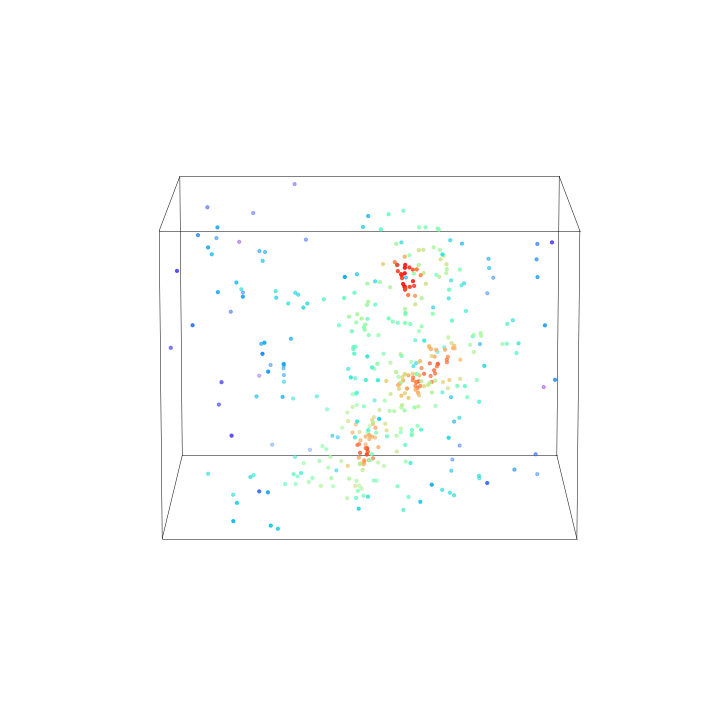

In [14]:
fig = plt.figure()
fig.set_size_inches(10,10)

fig.subplots_adjust(hspace=0.0, wspace=0.0, left=0.01, right=0.99, bottom=0.0, top=1.0)
ax = fig.add_subplot(1, 1, 1, projection='3d', facecolor="white")
ax.set_axis_off()
bbox = fig.bbox_inches.from_bounds(0.2, 0.8, 2.5, 1.6)

# RA, DEC, and Redshift limits
RA_min = 149.5; RA_max = 150.5
DEC_min = 1.75; DEC_max = 2.75
z_min = 2.42; z_max = 2.53
ang_scale = cosmo.kpc_comoving_per_arcmin(z_max).value/(1e3)*60.
cosm_dist = cosmo.comoving_distance(z_max).value - cosmo.comoving_distance(z_min).value

# Plot Box Plot
ax = boxplot(RA_min,RA_max,DEC_min,DEC_max,z_min,z_max,ax)


##### NOW PLOT THE GALAXIES
these_only = (cat["specz"] > z_min) & (cat["specz"] < z_max) & (cat['ra_corrected'] > RA_min) & (cat['ra_corrected'] < RA_max) & (cat['dec_corrected'] > DEC_min) & (cat['dec_corrected']< DEC_max) 
lss = ax.scatter(cat["ra_corrected"][these_only],cat["dec_corrected"][these_only],cat["specz"][these_only],c=sigma_dens[these_only], s=10,cmap="rainbow",norm=LogNorm())

def rotate(angle):
    ax.view_init(elev=10,azim=angle,roll=0)

# Make The GIF
rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 362, 4), interval=100)
#rot_animation.save('lowz_LSS.gif', dpi=300, writer='imagemagick')
HTML(rot_animation.to_jshtml())

